In [1]:
import sys
sys.path.insert(0, "src/")
import matplotlib
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from colors import color
import sklearn as sl
import skimage
from sklearn.metrics import mean_squared_error as MSE
from data import Sample, smooth, Spectra
from scipy.optimize import basinhopping
from camera import CameraCalibration
from tmm.tmm_core import coh_tmm, unpolarized_RT
import copy
import os
from scipy.integrate import trapz
from sklearn.cluster import dbscan, OPTICS, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn import manifold
from sklearn import mixture, cluster
from sklearn.decomposition import KernelPCA, PCA
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In /home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
from data import SpectraTheory, SyntheticSpectra, SampleArray, AttributeDict
from camera import CameraCalibration
from skimage.color import rgb2hsv, rgb2luv, rgb2hed, rgb2lab, rgb2hed, rgb2grey
from matplotlib.colors import hex2color, rgb2hex
from skimage.color import label2rgb
import matplotlib.patches as patches
from skimage.transform import rotate

In [3]:
DATA = 'data/'
METADATA = 'metadata/'

In [4]:
def plot_image_and_crop(image, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1,2,figsize=[10,5])
    ax1 = axes[0]
    ax2 = axes[1]
    ax1.imshow(image[:,:])
    rect = patches.Rectangle((yc-dy, xc-dx), dy*2, dx*2, linewidth=1, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    ax2.imshow(image[x_crop,y_crop])
    
def plot_colorspaces(*colorspaces):
    fig, axes = plt.subplots(len(colorspaces),2,figsize=(10,5*(len(colorspaces))))
    
    for hax, cspace in zip(axes,colorspaces):
        plot_image_and_crop(cspace, axes=hax) 
        
def show_cluster(labels, colors=None, cluster=1, ax=None):
    if ax is None:
        ax = plt.gca()
    labels = labels.copy()
    mask = labels == cluster
    labels[~mask] = 0
    if colors is None:
        ax.imshow(labels)
    else:
        colors = colors.copy()
        colors[~mask] = [0.0,0.0,0.0]
        ax.imshow(colors)

## Fake Cell

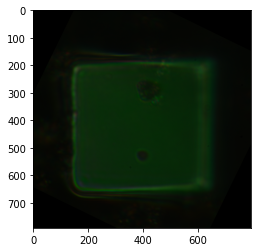

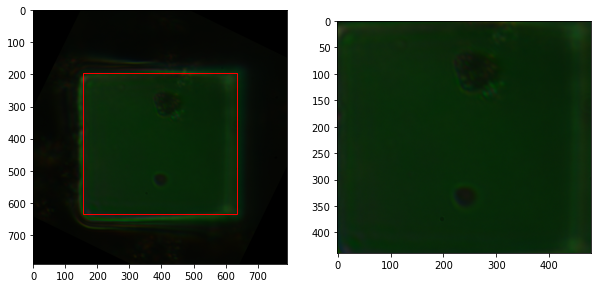

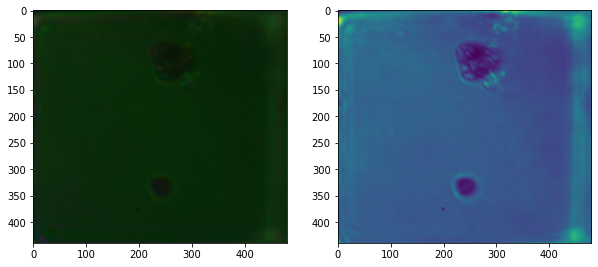

In [38]:
fname = DATA + 'final/Fake cells/crops/Green11_LU_crop.tif'
image = io.imread(fname)/2**14
image = rotate(image,-26)
wx, wy = image.shape[:2]
plt.imshow(image)
plt.show()
# dx = 300
# dy = 300
# xc, yc = (1100, 1800)
dx = 220
dy = 240
xc, yc = (wx // 2 + 20, wy // 2)
cut_x = [xc-dx,xc+dx]
cut_y = [yc-dy,yc+dy]
x_crop = slice(cut_x[0],cut_x[1])
y_crop = slice(cut_y[0],cut_y[1])
plot_image_and_crop(image)
plt.show()
plt.figure(figsize=[10,5])
plt.subplot(121)
grey_scale=rgb2grey(image[x_crop,y_crop])
plt.imshow(np.abs(image[x_crop,y_crop]))
plt.subplot(122)
tmp = grey_scale
plt.imshow(np.abs(tmp))
plt.show()

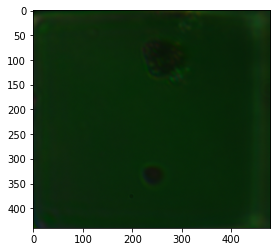

In [39]:
image = image[x_crop,y_crop]
plt.imshow(image)
plt.show()

220 240


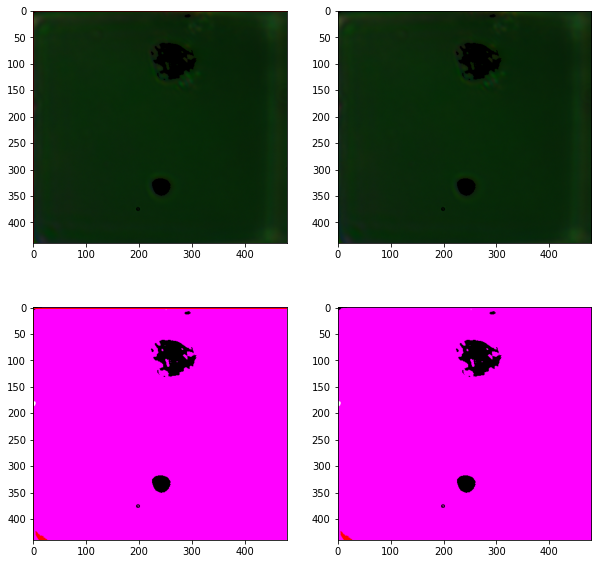

In [40]:
# fname = DATA + 'fake_cells/Second_try_LU_2ms.tif'
# image = io.imread(fname)/2**14
wx, wy = image.shape[:2]
dx = wx // 2
dy = wy // 2
xc = wx // 2
yc = wy // 2
print(xc,yc)
#xc, yc = (183, 372)

gray_img = rgb2grey(image)
cut_x = [xc-dx,xc+dx]
cut_y = [yc-dy,yc+dy]
x_crop = slice(cut_x[0],cut_x[1])
y_crop = slice(cut_y[0],cut_y[1])
th_up = 0.5
th_bottom = 0.1
bg_mask = (gray_img > th_up) | (gray_img < th_bottom) 
gray_img[bg_mask] = 0

rgb_img = image.copy()
rgb_img[bg_mask] = 0
rgb_colors = rgb_img[cut_x[0]:cut_x[1],cut_y[0]:cut_y[1]]

hsv_img = rgb2hsv(rgb_img)
hsv_colors = hsv_img[cut_x[0]:cut_x[1],cut_y[0]:cut_y[1]]
luv_img = rgb2luv(rgb_img)
luv_img=np.clip(luv_img,0,1)
luv_colors = luv_img[cut_x[0]:cut_x[1],cut_y[0]:cut_y[1]]

plot_colorspaces(rgb_img, luv_img)

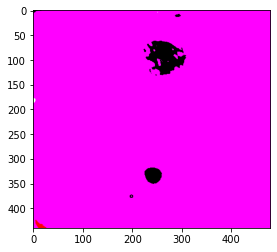

In [42]:
plt.figure()
plt.imshow(np.clip(luv_img,0,1))
plt.show()

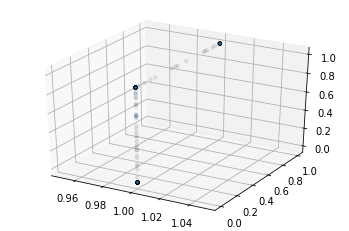

In [43]:
crop_mask = (luv_colors > 0).max(axis=-1).squeeze()
flat_hsv_colors = luv_colors[crop_mask].reshape(-1,3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(flat_hsv_colors[:, 0], flat_hsv_colors[:, 1], flat_hsv_colors[:, 2], marker='o', alpha=0.1,
            s=10, edgecolor='k')
plt.show()

In [44]:
clusters = [
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1]
]
luv_clusters = np.zeros((*luv_img.shape[:2],1+len(clusters)))
for i,cluster in enumerate(clusters,1):
    tmp = np.abs(luv_img - cluster).sum(axis=-1)
    tmp = np.minimum(tmp,1.0)
    luv_clusters[:,:,i] = 1-tmp

bg = [1] + [0] * len(clusters)
luv_clusters[bg_mask] = bg

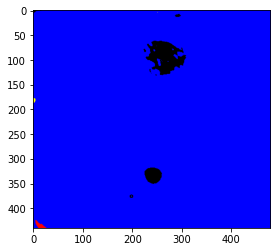

In [45]:
luv_labels = luv_clusters.argmax(axis=-1)
plt.figure()
plt.imshow(label2rgb(luv_labels,bg_label=0))
plt.show()

In [46]:
np.save(METADATA + 'fake_luv_labels_final.npy',luv_labels)
np.save(METADATA + 'fake_rgb_colors_luv_final.npy',rgb_img)

## Cancer Cell

1136 1648


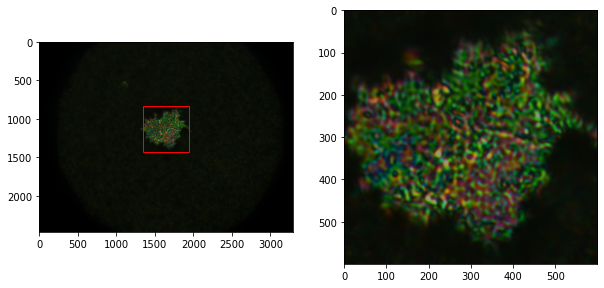

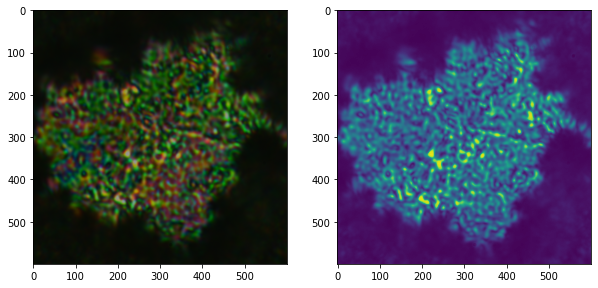

In [51]:
# image_dir = DATA + 'cancer/S14/Processed/'
# fname = image_dir + 'exp3_lu.tif'
image_dir = DATA + 'final/Real cells/'
fname = image_dir + 'realA_LU.tif'
image = io.imread(fname)/2**14
wx, wy = image.shape[:2]
dx = 300
dy = 300
xc = wx // 2 - 100
yc = wy // 2
print(xc,yc)
#xc, yc = (183, 372)

cut_x = [xc-dx,xc+dx]
cut_y = [yc-dy,yc+dy]
x_crop = slice(cut_x[0],cut_x[1])
y_crop = slice(cut_y[0],cut_y[1])

plot_image_and_crop(image)
plt.show()
plt.figure(figsize=[10,5])
plt.subplot(121)
grey_scale=rgb2grey(image[x_crop,y_crop])
plt.imshow(np.abs(image[x_crop,y_crop]))
plt.subplot(122)
tmp = grey_scale
plt.imshow(np.abs(tmp))
plt.show()

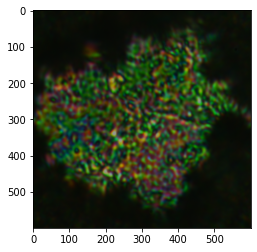

In [52]:
image = image[x_crop,y_crop]
plt.imshow(image)
plt.show()

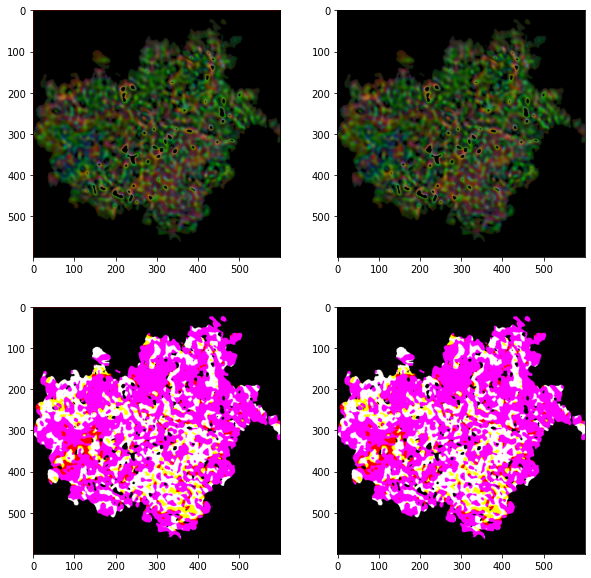

In [61]:
wx, wy = image.shape[:2]
gray_img = rgb2grey(image)
dx = wx//2
dy = wy//2
xc, yc = (wx//2, wy//2)
cut_x = [xc-dx,xc+dx]
cut_y = [yc-dy,yc+dy]
x_crop = slice(cut_x[0],cut_x[1])
y_crop = slice(cut_y[0],cut_y[1])
th_up = 0.5
th_bottom = 0.1
bg_mask = (gray_img > th_up) | (gray_img < th_bottom) 
gray_img[bg_mask] = 0

rgb_img = image.copy()
rgb_img[bg_mask] = 0
rgb_colors = rgb_img[cut_x[0]:cut_x[1],cut_y[0]:cut_y[1]]

hsv_img = rgb2hsv(rgb_img)
hsv_colors = hsv_img[cut_x[0]:cut_x[1],cut_y[0]:cut_y[1]]
luv_img = rgb2luv(rgb_img)
luv_img=np.clip(luv_img,0,1)
luv_colors = luv_img[cut_x[0]:cut_x[1],cut_y[0]:cut_y[1]]

plot_colorspaces(rgb_img, luv_img)

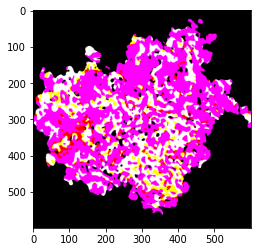

In [62]:
plt.figure()
plt.imshow(np.clip(luv_img,0,1))
plt.show()

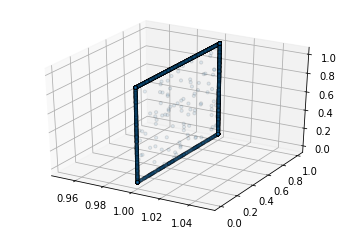

In [63]:
crop_mask = (luv_colors > 0).max(axis=-1).squeeze()
flat_hsv_colors = luv_colors[crop_mask].reshape(-1,3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(flat_hsv_colors[:, 0], flat_hsv_colors[:, 1], flat_hsv_colors[:, 2], marker='o', alpha=0.1,
            s=10, edgecolor='k')
plt.show()

In [64]:
clusters = [
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1]
]
luv_clusters = np.zeros((*luv_img.shape[:2],1+len(clusters)))
for i,cluster in enumerate(clusters,1):
    tmp = np.abs(luv_img - cluster).sum(axis=-1)
    tmp = np.minimum(tmp,1.0)
    luv_clusters[:,:,i] = 1-tmp

bg = [1] + [0] * len(clusters)
luv_clusters[bg_mask] = bg

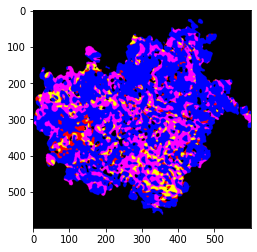

In [65]:
luv_labels = luv_clusters.argmax(axis=-1)
plt.figure()
plt.imshow(label2rgb(luv_labels,bg_label=0))
plt.show()

In [58]:
np.save(METADATA + 'cancer_luv_labels_final.npy',luv_labels)
np.save(METADATA + 'cancer_rgb_colors_luv_final.npy',rgb_img)